In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para visualizações
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [2]:
# Funções auxiliares para transformação de dados
def extract_runtime(X):
    """Extrai minutos do runtime"""
    return X.apply(lambda x: float(re.findall(r'(\d+)', str(x))[0]) if pd.notna(x) and re.findall(r'(\d+)', str(x)) else 0).to_frame()

def log_transform(X):
    """Aplica log transform para normalizar distribuição"""
    return np.log1p(X)

def clean_gross(X):
    """Limpa e converte valores monetários"""
    if X.dtype == object:
        return X.str.replace(',', '').str.replace('$', '').fillna('0').astype(float)
    return X

def primary_genre(X):
    """Extrai o gênero primário"""
    return X.str.split(',').str[0].fillna('Unknown').to_frame()

def extract_year(X):
    """Extrai o ano de lançamento"""
    return X.apply(lambda x: int(re.findall(r'\d{4}', str(x))[0]) if pd.notna(x) and re.findall(r'\d{4}', str(x)) else 0).to_frame()

In [4]:
# Carregar os dados
df = pd.read_csv("../data/imdb_top_1000.csv")

# Visualizar as primeiras linhas
print("Primeiras 5 linhas do dataset:")
display(df.head())

# Informações sobre o dataset
print("\nInformações do dataset:")
df.info()

# Estatísticas descritivas
print("\nEstatísticas descritivas:")
display(df.describe())

# Verificar valores nulos
print("\nValores nulos por coluna:")
display(df.isnull().sum())

Primeiras 5 linhas do dataset:


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB

Estatística

,IMDB_Rating,Meta_score,No_of_Votes
count,1000.000000,843.000000,1.000000e+03
mean,7.949300,77.971530,2.736929e+05
std,0.275491,12.376099,3.273727e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.552625e+04
50%,7.900000,79.000000,1.385485e+05
75%,8.100000,87.000000,3.741612e+05
max,9.300000,100.000000,2.343110e+06



Valores nulos por coluna:


Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [8]:
# Primeiro, vamos pré-processar os dados corretamente
print("Pré-processando dados...")

# Fazer uma cópia do dataframe
df_clean = df.copy()

# 1. Converter Runtime para numérico (extrair minutos)
df_clean['Runtime_min'] = df_clean['Runtime'].str.extract(r'(\d+)').astype(float)

# 2. Limpar e converter Gross para numérico
df_clean['Gross_clean'] = df_clean['Gross'].str.replace(',', '').str.replace('$', '').fillna('0').astype(float)

# 3. Extrair ano numérico de Released_Year
df_clean['Year_num'] = df_clean['Released_Year'].str.extract(r'(\d{4})').fillna('0').astype(int)

# 4. Preencher valores missing
df_clean['Meta_score'] = df_clean['Meta_score'].fillna(df_clean['Meta_score'].median())
df_clean['Certificate'] = df_clean['Certificate'].fillna('Unknown')
df_clean['Director'] = df_clean['Director'].fillna('Unknown')

# Verificar resultado
print("Dados pré-processados:")
display(df_clean[['Runtime_min', 'Gross_clean', 'Year_num', 'Meta_score', 'Certificate']].head())

Pré-processando dados...
Dados pré-processados:


,Runtime_min,Gross_clean,Year_num,Meta_score,Certificate
0,142.0,28341469.0,1994,80.0,A
1,175.0,134966411.0,1972,100.0,A
2,152.0,534858444.0,2008,84.0,UA
3,202.0,57300000.0,1974,90.0,A
4,96.0,4360000.0,1957,96.0,U


In [9]:
# Preparar dados para treinamento
features = ['Runtime_min', 'No_of_Votes', 'Gross_clean', 'Meta_score', 
            'Certificate', 'Genre', 'Director', 'Overview', 'Year_num']
target = 'IMDB_Rating'

X = df_clean[features]
y = df_clean[target]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

# Mostrar tipos de dados para verificação
print("\nTipos de dados das features:")
print(X_train.dtypes)

Tamanho do conjunto de treino: (800, 9)
Tamanho do conjunto de teste: (200, 9)

Tipos de dados das features:
Runtime_min    float64
No_of_Votes      int64
Gross_clean    float64
Meta_score     float64
Certificate     object
Genre           object
Director        object
Overview        object
Year_num         int64
dtype: object


In [10]:
# Pipeline simplificado e corrigido
def build_pipeline():
    # Transformações para features numéricas
    numeric_features = ['Runtime_min', 'No_of_Votes', 'Gross_clean', 'Meta_score', 'Year_num']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Transformações para features categóricas
    categorical_features = ['Certificate', 'Director']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Transformação especial para Genre (pode ter múltiplos gêneros)
    genre_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Transformação para texto (Overview)
    text_transformer = TfidfVectorizer(
        stop_words='english', 
        max_features=500,  # Reduzido para melhor performance
        ngram_range=(1, 2)
    )
    
    # Pré-processador completo
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('genre', genre_transformer, ['Genre']),
            ('text', text_transformer, 'Overview')
        ],
        remainder='drop'
    )
    
    # Pipeline final
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=50,  # Reduzido para teste mais rápido
            random_state=42,
            n_jobs=-1,
            verbose=1
        ))
    ])
    
    return pipeline

In [11]:
# Construir e treinar o pipeline
print("Iniciando treinamento do modelo...")
pipeline = build_pipeline()
pipeline.fit(X_train, y_train)

print("Treinamento concluído!")

Iniciando treinamento do modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Treinamento concluído!


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


Métricas de avaliação do modelo:
MSE: 0.0341
RMSE: 0.1846
MAE: 0.1460
R²: 0.4685


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


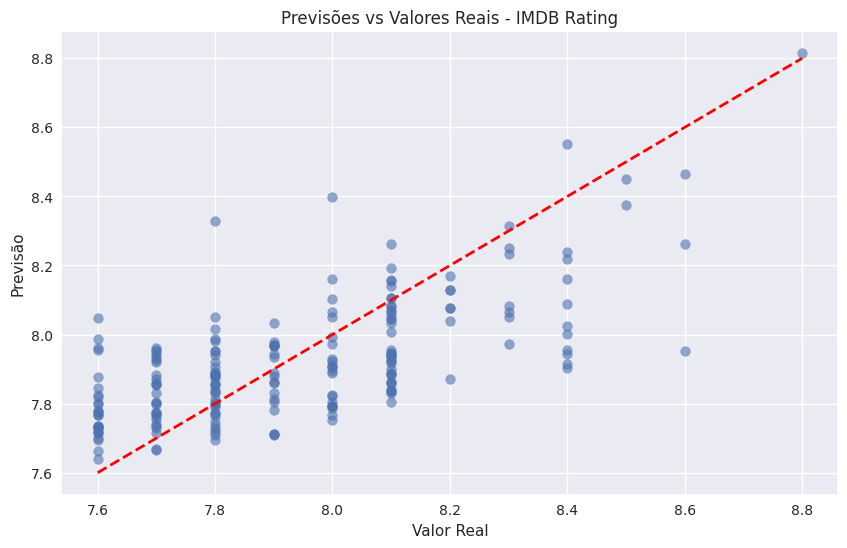

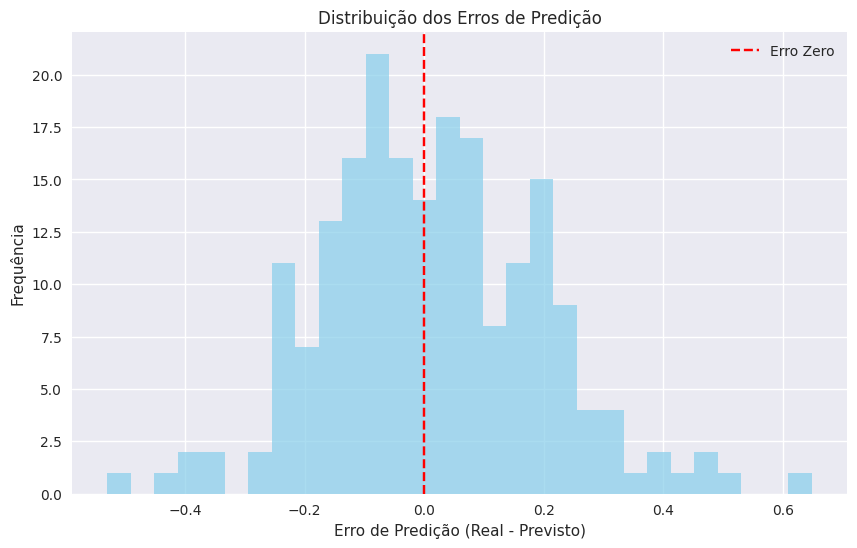

In [12]:
# Fazer previsões
y_pred = pipeline.predict(X_test)

# Calcular métricas
metrics = {
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    'R²': r2_score(y_test, y_pred)
}

print("Métricas de avaliação do modelo:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualizar previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Previsão')
plt.title('Previsões vs Valores Reais - IMDB Rating')
plt.grid(True)
plt.show()

# Histograma dos erros
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='skyblue')
plt.xlabel('Erro de Predição (Real - Previsto)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros de Predição')
plt.axvline(x=0, color='r', linestyle='--', label='Erro Zero')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Preparar dados do novo filme
sample_movie = {
    'Runtime_min': 142.0,
    'No_of_Votes': 2343110,
    'Gross_clean': 28341469.0,
    'Meta_score': 80.0,
    'Certificate': 'A',
    'Genre': 'Drama',
    'Director': 'Frank Darabont',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Year_num': 1994
}

# Converter para DataFrame
movie_df = pd.DataFrame([sample_movie])

# Fazer previsão
predicted_rating = pipeline.predict(movie_df)[0]
print(f"Previsão de nota para 'The Shawshank Redemption': {predicted_rating:.2f}")

# Comparar com valor real
actual_rating = df_clean[df_clean['Series_Title'] == 'The Shawshank Redemption']['IMDB_Rating'].values[0]
print(f"Nota real: {actual_rating:.2f}")
print(f"Diferença: {abs(actual_rating - predicted_rating):.2f}")

Previsão de nota para 'The Shawshank Redemption': 9.05
Nota real: 9.30
Diferença: 0.25


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [16]:
# Salvar o modelo
import os

# Criar diretório se não existir
os.makedirs('models', exist_ok=True)

with open('../models/imdb_rating_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Modelo salvo com sucesso em '..models/imdb_rating_model.pkl'")

Modelo salvo com sucesso em '..models/imdb_rating_model.pkl'
